<div align="center" vertical-align="middle">
  <a><img height="200px" src="../../docs/scapy-logo-named-cropped.png"></a>
  <h1>Userguide for synthetic CDM data generation</h1>
</div>



#### Table of contents
1. Environment set-up
2. Data preparation
    1. Importing first Conjunction Data Messages from events 
    2. Normalising covariance data
3. Synthetic Data Generator model configuration
    1. Synthetic data generation using KDE with MSE-CV bandwidth selection
    2. Synthetic data generation using SciPy distribution


## 1.- Environment set-up

In [1]:
# Get current working directory path for the tool parent folder and add it to 
# the system path
from importlib import reload
from pathlib import Path
import os
foldername = 'scapy'
cwd = str(Path(os.getcwd()[:os.getcwd().index(foldername)+len(foldername)]))

# Add library path to system path if it is not included already.
import sys
if cwd not in sys.path: sys.path.append(cwd)
print(f'Current working directory: {cwd}')

# Import utils library containing miscellaneous functions/classes
from scapy import utils

# Show plots in the notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
rc('text', usetex=True)

Current working directory: /Users/jjrr/Documents/SCA-Project/scapy


## 2.- Data preparation

### 2.1.- Importing first Conjunction Data Messages from events

In [2]:
from scapy import ccsds
from scapy import data
import pandas as pd

# Use data from Kelvins competition:
# https://kelvins.esa.int/collision-avoidance-challenge/data/

# Download testing data from Kelvins website
filepath = data.get_kelvins_data(data = 'train', return_ced = False,
                                 overwrite = False, num_events = None)

# Get only last CDM data from every event_id
df_firstCDM = pd.read_csv(filepath).drop_duplicates('__EVENT_ID', keep='first')

# Cast all columns as the CCSDS format.
df_firstCDM = df_firstCDM.astype(ccsds.df_dtype_conversion)

display(df_firstCDM.head(5))

,CCSDS_CDM_VERS,CREATION_DATE,ORIGINATOR,MESSAGE_FOR,MESSAGE_ID,TCA,MISS_DISTANCE,RELATIVE_SPEED,RELATIVE_POSITION_R,RELATIVE_POSITION_T,...,OBJECT2_CTHR_NDOT,OBJECT2_CTHR_DRG,OBJECT2_CTHR_SRP,OBJECT2_CTHR_THR,__MAX_RISK_ESTIMATE,__MAX_RISK_SCALING,__CREATION_DATE,__TCA,__DAYS_TO_TCA,__EVENT_ID
0,1.0,2023-10-14 02:44:53.431001,<NA>,<NA>,<NA>,2023-10-15 16:21:04.798001,14923.0,13792.0,453.8,5976.6,...,NaN,NaN,NaN,NaN,-7.834756,8.602101,0.0,1.566798,1.566798,0
5,1.0,2023-10-09 03:37:13.477001,<NA>,<NA>,<NA>,2023-10-15 16:21:04.798001,2392.0,3434.0,74.3,2317.1,...,NaN,NaN,NaN,NaN,-7.254301,2.746782,0.0,6.530455,6.530455,1
9,1.0,2023-10-08 16:44:52.686001,<NA>,<NA>,<NA>,2023-10-15 16:21:04.798001,22902.0,14348.0,-1157.6,-6306.2,...,NaN,NaN,NaN,NaN,-6.601713,13.293159,0.0,6.983474,6.983474,2
29,1.0,2023-10-08 17:32:57.225001,<NA>,<NA>,<NA>,2023-10-15 16:21:04.798001,29654.0,13574.0,19.2,12494.9,...,NaN,NaN,NaN,NaN,-7.057793,8.965371,0.0,6.950088,6.950088,3
50,1.0,2023-10-10 17:09:41.324001,<NA>,<NA>,<NA>,2023-10-15 16:21:04.798001,31612.0,12093.0,182.4,-18561.7,...,NaN,NaN,NaN,NaN,-6.800245,5.111282,0.0,4.966244,4.966244,4


### 2.2.- Using OBJECT1 covariance data normalised as an example

In [ ]:
# Get list of obligatory features.
features = ccsds.get_features(only_names = True, 
                              include_object_preffix = True, 
                              **dict(obligatory = True,
                                     cluster = ['data_covariance']))

# Get only the covariance matrix elements for OBJECT1 as an example.
features = [f for f in features if f.startswith('OBJECT1')]
display(features)

In [4]:
import numpy as np

# Initialice list of covariance matrix components
rtn_components = ['R', 'T', 'N', 'RDOT', 'TDOT', 'NDOT']

dft_firstCDM = df_firstCDM.copy()

for feature in features:

    # Get the RTN components from the feature
    obj = feature.split('_')[0]
    i_rtn = feature.split('_')[1][1:]
    j_rtn = feature.split('_')[2]

    # Get variance of the components (used to scale the other terms of the
    # covariance matrix)
    i_sigma = df_firstCDM[f'{obj}_C{i_rtn}_{i_rtn}'].to_numpy()
    j_sigma = df_firstCDM[f'{obj}_C{j_rtn}_{j_rtn}'].to_numpy()

    # Switch the dataframe to use when plotting the feature.
    data = df_firstCDM[feature].to_numpy()

    # Check what element of the covariance matrix it is being processed.
    if i_rtn == j_rtn:
        # If feature is one of the main diagonal components (sigma), apply 
        # logarithmic scaling.
        data = np.log(data)
    else:
        # Otherwise scale covariance matrix element using the variances of
        # both components
        data = data/(i_sigma * j_sigma)**0.5

    # Update values in the DataFrame containing transformed data.
    dft_firstCDM[feature] = data

# Plot normalised data
display(dft_firstCDM[features].head(5))


,OBJECT1_CR_R,OBJECT1_CT_R,OBJECT1_CT_T,OBJECT1_CN_R,OBJECT1_CN_T,OBJECT1_CN_N,OBJECT1_CRDOT_R,OBJECT1_CRDOT_T,OBJECT1_CRDOT_N,OBJECT1_CRDOT_RDOT,...,OBJECT1_CTDOT_T,OBJECT1_CTDOT_N,OBJECT1_CTDOT_RDOT,OBJECT1_CTDOT_TDOT,OBJECT1_CNDOT_R,OBJECT1_CNDOT_T,OBJECT1_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT1_CNDOT_NDOT
0,2.801347,-0.397969,9.848951,0.292258,0.040799,1.154820,0.394221,-0.999674,-0.038498,-3.829888,...,0.214612,-0.316493,-0.210247,-10.997512,0.170737,-0.001551,0.531593,0.002117,-0.179278,-11.627257
5,3.739644,-0.134713,11.110971,0.126515,-0.023597,3.111365,0.108845,-0.998856,0.018619,-2.557722,...,0.107629,-0.126921,-0.081454,-9.929384,-0.096789,-0.082136,0.810101,0.085601,0.099044,-10.945961
9,4.403099,-0.099768,9.989217,0.357995,-0.122174,0.992620,0.085472,-0.999674,0.121504,-3.750303,...,0.057809,-0.353866,-0.043471,-9.340532,-0.025138,0.087954,-0.430583,-0.088821,0.021409,-11.100799
29,3.480322,-0.087312,12.251246,0.098330,0.033053,1.981860,0.061782,-0.999429,-0.034312,-1.462967,...,0.046797,-0.099833,-0.021124,-10.227397,0.077394,-0.011649,0.336194,0.013638,-0.076656,-9.141744
50,4.259142,-0.331147,11.434297,-0.107863,0.070392,3.804487,0.278666,-0.997821,-0.065769,-2.305406,...,0.269174,0.105238,-0.215500,-9.471053,0.158920,0.007587,0.349890,-0.008566,-0.160701,-10.336490


### 2.3.- Plot histograms

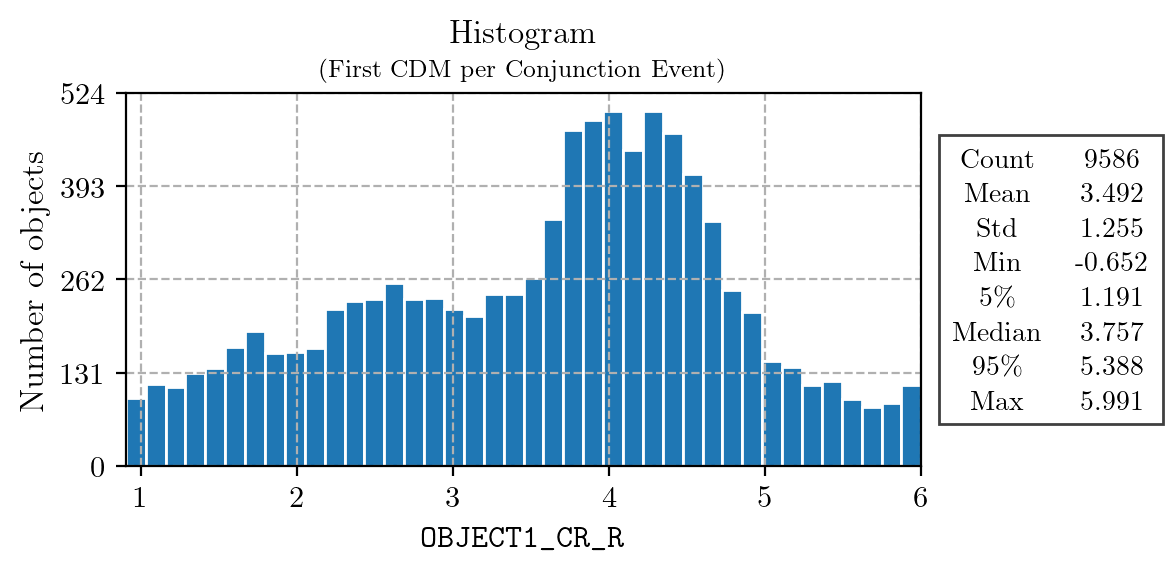

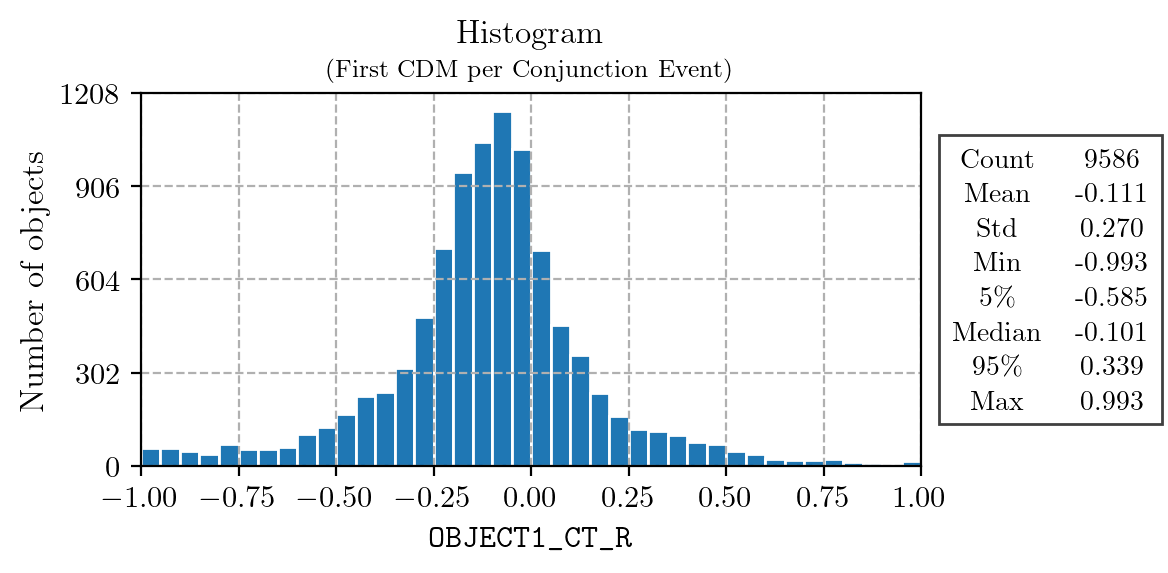

In [5]:
import numpy as np

for feature in features[:2]:

    # Get the RTN components from the feature
    obj = feature.split('_')[0]
    i_rtn = feature.split('_')[1][1:]
    j_rtn = feature.split('_')[2]

    # Update values in the DataFrame containing transformed data.
    data = dft_firstCDM[feature] 

    # Define kwargs for the histogram
    kwargs = {'title': f'Histogram\n \small (First CDM per Conjunction Event)', 
            'xlim':(-1,1) if i_rtn != j_rtn else None,
            'color':'tab:blue' if obj.endswith('1') else 'tab:orange'}

    utils.plot_histogram(data = data, 
                         features = feature, 
                         show_stats = True,
                         show = False, **kwargs)


## 3. - Synthetic Data Generator model instanciation

### 3.1.- Synthetic data generation using KDE with MSE-CV bandwidth selection


FITTING SCIPY DISTRIBUTIONS:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (106/106)| 00h:00m:32s |   3.30    | Max R2 = 8.7834e-01                             

Estimating optimal bandwidth for Gaussian Kernel Density... Optimal bandwidth = 4.00e-01.

SyntheticDataGenerator:
  Method:    Non-Parametric
  Kernel:    gaussian
  Bandwidth: 0.4
  Algorithm: auto


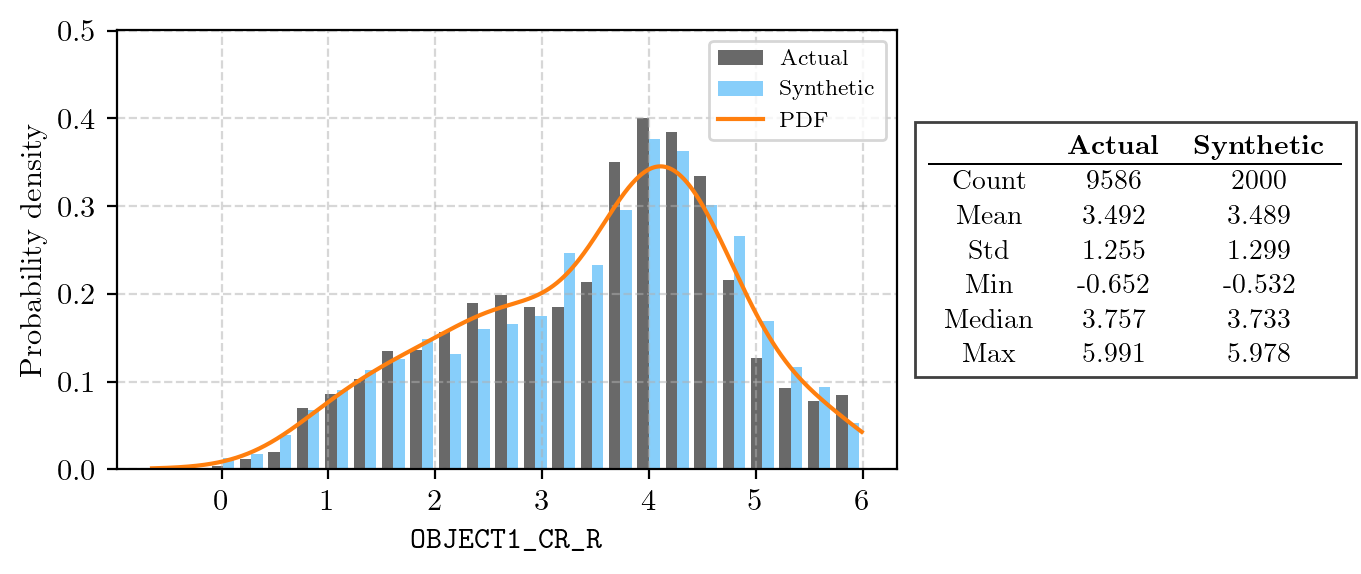

In [8]:
# Import model
from scapy.sdg import SyntheticDataGenerator

# Define feature to simulate
feature = 'OBJECT1_CR_R'

# Set column name to study and remove outliers. 
data = dft_firstCDM[feature].dropna().to_numpy()

# Get the filename of filepath where the parameters are saved.
filename = f'SDG-{feature}'
filepath = os.path.join(cwd, 'models','parameters', 'sdg', filename + '.pkl')

# Get synthetic object
model = SyntheticDataGenerator(data = data, filepath = filepath)

# Print Synthetic Data Generator model
print(model)

# Plot feature
model.plot_histogram(figsize = (7, 3), 
                     xlabel = r'\texttt{' + feature + '}',
                     show_stats = True)

### 3.2.- Synthetic data generation using SciPy distribution


FITTING SCIPY DISTRIBUTIONS:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (106/106)| 00h:00m:30s |   3.42    | Max R2 = 9.8105e-01                             

SyntheticDataGenerator:
  Method:       Parametric
  Distribution: skewnorm
  Parameters:
   - a     = 3.7822101174586322
   - loc   = 0.5965137432915376
   - scale = 1.5876501003456984


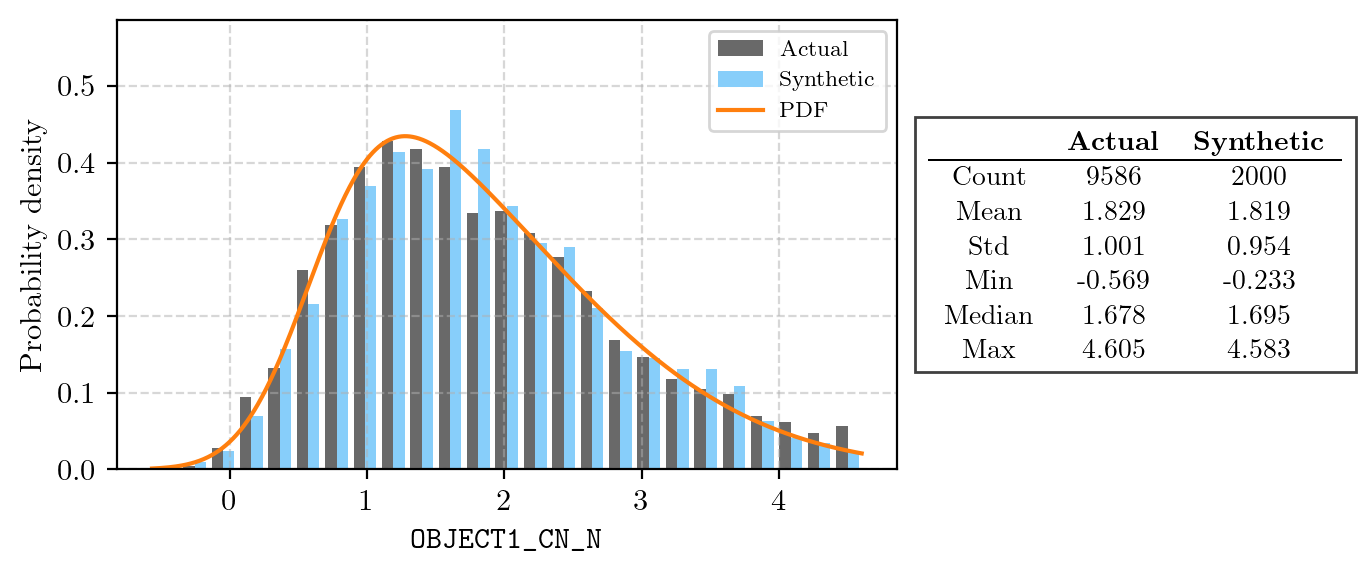

In [9]:
# Import model
from scapy.sdg import SyntheticDataGenerator

# Define feature to simulate
feature = 'OBJECT1_CN_N'

# Set column name to study and remove outliers. 
data = dft_firstCDM[feature].dropna().to_numpy()

# Get the filename of filepath where the parameters are saved.
filename = f'SDG-{feature}'
filepath = os.path.join(cwd, 'models','parameters', 'sdg', filename + '.pkl')

# Get synthetic object
model = SyntheticDataGenerator(data = data, filepath = filepath)

# Print Synthetic Data Generator model
print(model)

# Plot feature
model.plot_histogram(figsize = (7, 3), 
                     xlabel = r'\texttt{' + feature + '}',
                     show_stats = True)